In [79]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.metrics import confusion_matrix

pd.options.display.max_colwidth = 1000

# Utility function to create a list of the most common words in a given document.
def bag_of_words(nlp_doc, n, minlen=4, maxlen=99):

    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in nlp_doc
                if not token.is_punct    #disregard punctuation
                and not token.is_stop    #disregard stop words
                and not token.pos_ == 'PROPN'   #disregard proper nouns
                and not token.lemma_ in ['-PRON-','-lrb-','-rrb-','``',"'s",'`']
                #and token.pos_ in ['ADJ','ADV']
                 ]   
    
    # Return the most common words.
    return [item for item in Counter(allwords).most_common(n)]
    

def my_confusion_matrix(array_Expected,array_Predicted,colName):
    a = np.array(confusion_matrix(array_Expected, array_Predicted ))
    totalExpectedFalse = a[0,0] + a[0,1]
    totalExpectedTrue = a[1,0] + a[1,1]
    correctFalse = a[0,0] 
    correctTrue = a[1,1] 
    correctTruePct = np.round(correctTrue / totalExpectedTrue,3)
    correctFalsePct = np.round(correctFalse / totalExpectedFalse,3)
    print('Regarding ' + colName + '...')
    print('The model correctly predicted {} Negatives out of {} expected Negatives: {}'.format(
        correctFalse,totalExpectedFalse,correctFalsePct))
    print('The model correctly predicted {} Positives out of {} expected Positives: {}'.format(
        correctTrue,totalExpectedTrue,correctTruePct))    
    print(a)


In [6]:
 # Load the data
raw_data = pd.read_table('train.tsv')


# Keep the labeled rows only
prior_SentenceID = 0
i = 0
keep_list = []
for row in raw_data.itertuples():
    if row.SentenceId != prior_SentenceID:
        keep_list.append(i)
    
    i = i+1
    prior_SentenceID = row.SentenceId


reviews = raw_data.loc[keep_list]
    
    
#Create labels (rating 0,1 is Negative;  rating 3,4 is Positive; rating 2 is Neutral)
def label_rows(row):
    if row['Sentiment'] in (0,1):
        return 0
    elif row['Sentiment'] in (3,4):
        return 1
    else:
        return -1


reviews['Label'] = reviews.apply(label_rows, axis=1)
reviews.reset_index(inplace=True)
reviews.drop(columns=['index','PhraseId','SentenceId'], inplace=True)
reviews.loc[reviews.Label >= 0].describe()


# The sentiment labels are:

# 0 - negative
# 1 - somewhat negative
# 2 - neutral
# 3 - somewhat positive
# 4 - positive


,Sentiment,Label
count,6874.000000,6874.000000
mean,2.078411,0.524003
std,1.421639,0.499460
min,0.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,1.000000
75%,3.000000,1.000000
max,4.000000,1.000000


In [81]:
%%time
#combine all reviews into a corpus of reviews
print('Determining Most Frequently used words in all Reviews...')
nlp = spacy.load('en')
all_doc = nlp(' '.join(reviews.Phrase))
all_words = bag_of_words(all_doc, 1000)
all_words_df = pd.DataFrame(all_words)
all_words_df = all_words_df.groupby([0]).sum().sort_values(by=1, ascending=False)
frequent_words = list(all_words_df[0:1000].index)
print(all_words_df)

Determining Most Frequently used words in all Reviews...
                 1
0                 
be            1396
film          1284
the           1253
movie         1150
a              877
n't            680
good           539
like           526
story          376
character      346
time           299
work           281
comedy         280
this           254
feel           252
make           246
funny          236
way            233
performance    228
bad            226
look           222
life           218
come           211
little         205
an             191
director       185
thing          169
love           169
watch          161
go             153
...            ...
punch           14
demonstrate     14
excitement      14
community       14
television      14
amazing         14
price           14
pretension      14
unfold          13
anti            13
soon            13
impression      13
poetic          13
consistently    13
setting         13
maker           13
blend       

In [103]:
def bow_features(nlp_list, word_list):

    print('Creating bag of words features...')
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=word_list)
    size = nlp_list.shape[0]
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, review in enumerate(nlp_list):
        
        item = nlp(review)
        if i % 500 == 0:
            print('Processing ' + str(i) + ' of ' + str(size)) 
        
        df.loc[i, word_list] = 0
        
        found_words = [token.lemma_ for token in item
                    if token.lemma_ in word_list]
        
        for word in found_words:
            df.loc[i, word] += 1
                 
    df.fillna(0,inplace=True)
    print('Shape with Bag of Words Features: ' + str(df.shape))
    return df


def spacy_features(nlp_list):

    print('Creating spacy features...')
    df = pd.DataFrame()
    
    # Process each row
    for i, review in enumerate(nlp_list):
        
        item = nlp(review)
        if i % 500 == 0:
            print('Processing ' + str(i))
        
        #features: populate sentence length
        df.loc[i,'numwords'] = len(item)
        
        bool_upper = 0
        num_repeat = 0
        prior_token = ''
                  
        for token in item:
         
            if token.is_upper == True:
                bool_upper = 1
            
            if token.norm_ == prior_token:
                num_repeat = num_repeat +1
   
            prior_token = token.norm_
 
        #feature: Num Uppercase words
        df.loc[i,'upperword'] = bool_upper   #np.where(len(uppers) > 0, 1, 0)
        
        #feature: repeats
        df.loc[i,'numrepeat'] = num_repeat
            
    df.fillna(0,inplace=True)
    print('Shape with Spacy Features: ' + str(df.shape))
    return df


from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
# create a spaCy tokenizer
spacy.load('en')


# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    tokens = nlp(doc)
    
    tokenlist = [token.lemma_ for token in tokens 
                if not token.is_punct    #disregard punctuation
                and not token.is_stop    #disregard stop words
                and not token.pos_ == 'PROPN'   #disregard proper nouns
                and not token.lemma_ in ['-PRON-','-lrb-','-rrb-','``',"'s",'`']
                ]
    
    return tokenlist


def tfidf_features(collection):
    #---------------------  VECTORIZE THE LIST  -----------------------
    print('Number of documents in collection: ' + str(len(collection)))
    print('Creating tfidf features....')

    vectorizer = TfidfVectorizer(tokenizer=my_tokenizer,
            strip_accents='ascii',
            ngram_range=(1,5),
             max_df=0.5, # drop words that occur in more than half the paragraphs
             min_df=3, # only use words that appear at least twice
             stop_words='english', 
             lowercase=False, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
    )


    #Applying the vectorizer 
    #Takes in a list of documents and applies features
    #return a sparse matrix
    collection_tfidf=vectorizer.fit_transform(collection)

    #--------------  Put Vector results into dataframe ----------
    #Convert sparse matrix into a dataframe
    collection_tfidf_csr = collection_tfidf.tocsr()
    features = vectorizer.get_feature_names()
    df = pd.DataFrame(collection_tfidf_csr.A, index=collection, columns=features)
    df.reset_index(inplace=True)
    df.drop(columns='Phrase', inplace=True)
    
    print('Shape with TF-IDF Features: ' + str(df.shape))
    return df


def tfidf_features_to_pca(X_train_tfidf, nlp_list, n_features):
    #---------------------  REDUCE FEATURES VIA PCA / SVD -----------------------
    print('Running SVD to reduce feature space')
    print('Shape before reducing to SVD/PCA features: ' + str(X_train_tfidf.shape))
    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer
    #Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
    svd= TruncatedSVD(n_features)
    X_train_lsa = svd.fit_transform(X_train_tfidf)
    print('Shape after reducing to SVD/PCA features: ' + str(X_train_lsa.shape))

    #---------------------  EXPLAINING VARIANCE FROM PCA -----------------------    
    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    print("Percent variance captured by all components:",total_variance*100)
    #Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
    items_by_component=pd.DataFrame(X_train_lsa, index=X_train_tfidf.index)
    
    print(items_by_component.shape)
    print(nlp_list.shape)
    df = pd.concat([nlp_list, items_by_component], axis=1)
    
    print(df.columns)
    
    for i in range(5):
         print('Component {}:'.format(i))
         print(df.loc[:,[i,'Phrase']].sort_values(by=i, ascending=False)[0:10])
    

    return X_train_lsa


from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def model_run_randomforest(reviews_df):
    
    print('\nTesting random forest model...')
    #Split into train and test
    reviews_no_neutrals = reviews_df.loc[reviews_df.Label >= 0]
    reviews_neutrals_only = reviews_df.loc[reviews_df.Label == -1]

    Y = reviews_no_neutrals.Label
    X = reviews_no_neutrals.drop(columns=['Sentiment','Phrase','Label'])

    X_Train = X.loc[0:5500]
    Y_Train = Y.loc[0:5500]

    X_Test = X.loc[5500:]
    Y_Test = Y.loc[5500:]

    X_Test_Neutrals_Only = reviews_neutrals_only.drop(columns=['Sentiment','Phrase','Label'])

    print('\nShape No Neutrals: ' + str(reviews_no_neutrals.shape))
    print('Shape Neutrals Only: ' + str(reviews_neutrals_only.shape))
    
    
    #Run Model
    rfc = ensemble.RandomForestClassifier(n_estimators=150, max_depth=40)

    train = rfc.fit(X_Train, Y_Train)

    print('\nRF: Training set score:', rfc.score(X_Train, Y_Train))
    print('RF: Test set score:', rfc.score(X_Test, Y_Test))

    Y_Pred = rfc.predict(X_Test)
    my_confusion_matrix(Y_Test, Y_Pred, "Reviews")

    Y_Pred_Neutrals_Only = rfc.predict_proba(X_Test_Neutrals_Only)

    plt.hist(Y_Pred_Neutrals_Only[:,1], alpha=.5, label='Random Forest')
    plt.title('Probabiliy of Neutral Review scored as positive')

    score = cross_val_score(rfc, X, Y, cv=4)
    print("\nRF: Cross Validation Accuracy %i folds: %.2f (+/- %.2f)" % (5, score.mean(), (score.std() * 2)))

    feature_importance = rfc.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    fi = pd.DataFrame(feature_importance, index=X_Train.columns, columns=['Importance'])
    print(fi.sort_values(by='Importance', ascending=False).head(30))
    

def model_neural_network(reviews_df):
    
    print('\nTesting Neural Network Model...')
    #Split into train and test
    reviews_no_neutrals = reviews_df.loc[reviews_df.Label >= 0]
    reviews_neutrals_only = reviews_df.loc[reviews_df.Label == -1]

    Y = reviews_no_neutrals.Label
    X = reviews_no_neutrals.drop(columns=['Sentiment','Phrase','Label'])

    X_Train = X.loc[0:5500]
    Y_Train = Y.loc[0:5500]

    X_Test = X.loc[5500:]
    Y_Test = Y.loc[5500:]

    X_Test_Neutrals_Only = reviews_neutrals_only.drop(columns=['Sentiment','Phrase','Label'])

    print('\nShape No Neutrals: ' + str(reviews_no_neutrals.shape))
    print('Shape Neutrals Only: ' + str(reviews_neutrals_only.shape))
    
    #Run Model
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(100), max_iter=250, activation='logistic' )
    train = mlp.fit(X_Train, Y_Train)
    
    print('\nNN: Training set score:', mlp.score(X_Train, Y_Train))
    print('NN: Test set score:', mlp.score(X_Test, Y_Test))
    
    Y_Pred = mlp.predict(X_Test)
    my_confusion_matrix(Y_Test, Y_Pred, "Reviews")

    Y_Pred_Neutrals_Only = mlp.predict_proba(X_Test_Neutrals_Only)
    
    plt.hist(Y_Pred_Neutrals_Only[:,1], alpha=.5, label='Neural Network')
    plt.title('Probabiliy of Neutral Review scored as positive')
    plt.legend(loc='upper right')
    
    score = cross_val_score(mlp, X, Y, cv=4)
    print("\nNN: Cross Validation Accuracy %i folds: %.2f (+/- %.2f)" % (4, score.mean(), (score.std() * 2)))





Creating bag of words features...
Processing 0 of 8529
Processing 500 of 8529
Processing 1000 of 8529
Processing 1500 of 8529
Processing 2000 of 8529
Processing 2500 of 8529
Processing 3000 of 8529
Processing 3500 of 8529
Processing 4000 of 8529
Processing 4500 of 8529
Processing 5000 of 8529
Processing 5500 of 8529
Processing 6000 of 8529
Processing 6500 of 8529
Processing 7000 of 8529
Processing 7500 of 8529
Processing 8000 of 8529
Processing 8500 of 8529
Shape with Bag of Words Features: (8529, 1000)

Testing random forest model...

Shape No Neutrals: (6874, 1003)
Shape Neutrals Only: (1655, 1003)

RF: Training set score: 0.9279909706546275
RF: Test set score: 0.7010224948875255
Regarding Reviews...
The model correctly predicted 710 Negatives out of 1164 expected Negatives: 0.61
The model correctly predicted 1004 Positives out of 1281 expected Positives: 0.784
[[ 710  454]
 [ 277 1004]]

RF: Cross Validation Accuracy 5 folds: 0.71 (+/- 0.02)
             Importance
and          100.

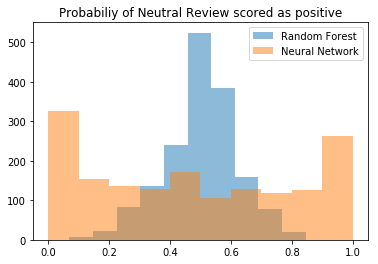

In [83]:
#Create bag of words feature set
features_bow = bow_features(reviews['Phrase'], frequent_words)
#features_spacy = spacy_features(reviews['Phrase'])
reviews_features_bow = pd.concat([reviews, features_bow], axis=1)
model_run_randomforest(reviews_features_bow)
model_neural_network(reviews_features_bow)

Number of documents in collection: 8529
Creating tfidf features....
Shape with TF-IDF Features: (8529, 5014)

Testing random forest model...

Shape No Neutrals: (6874, 5017)
Shape Neutrals Only: (1655, 5017)

RF: Training set score: 0.8562076749435666
RF: Test set score: 0.6867075664621677
Regarding Reviews...
The model correctly predicted 626 Negatives out of 1164 expected Negatives: 0.538
The model correctly predicted 1053 Positives out of 1281 expected Positives: 0.822
[[ 626  538]
 [ 228 1053]]

RF: Cross Validation Accuracy 5 folds: 0.69 (+/- 0.00)
             Importance
n't          100.000000
bad           93.318793
movie         56.539713
performance   46.121251
love          43.344947
film          41.013233
fun           37.031249
good          35.922081
work          33.592196
heart         28.918861
plot          27.515380
like          25.599395
lack          24.824774
dull          20.899673
think         20.494230
year          20.219117
solid         19.482970
come    

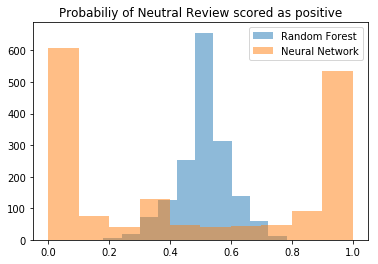

In [106]:
#Create tfidf feature set
features_tfidf = tfidf_features(reviews['Phrase'])
reviews_features_tfidf = pd.concat([reviews, features_tfidf], axis=1)
model_run_randomforest(reviews_features_tfidf)
model_neural_network(reviews_features_tfidf)

In [107]:
a = tfidf_features_to_pca(features_tfidf, reviews.Phrase, 3000)

Running SVD to reduce feature space
Shape before reducing to SVD/PCA features: (8529, 5014)
Shape after reducing to SVD/PCA features: (8529, 3000)
Percent variance captured by all components: 93.44365274935491
(8529, 3000)
(8529,)
Index(['Phrase',        0,        1,        2,        3,        4,        5,
              6,        7,        8,
       ...
           2990,     2991,     2992,     2993,     2994,     2995,     2996,
           2997,     2998,     2999],
      dtype='object', length=3001)
Component 0:
             0                                      Phrase
2741  0.594292                   Where 's the movie here ?
8309  0.594292                       Merci pour le movie .
3022  0.594292             This is one baaaaaaaaad movie .
3364  0.594292                     Who is this movie for ?
3518  0.594292     Igby Goes Down is one of those movies .
1181  0.594292       But here 's a movie about it anyway .
1899  0.594292  Secretary is not a movie about fetishism .
3978  0.5